In [2]:
## Implementing Logistic regression functionality using Single layer single Node(Neuron) to classify the Image is Cat or not

## Importing the required libraries.

import numpy as np
import matplotlib.pyplot as plt
import scipy
import h5py
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset
import cv2


In [3]:
##Loading the dataset (Cat or non cat)
## y =1 ( cat)
## y = 0 ( non cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [3]:
#train_set_x_orig = train_dataset['train_set_x'][:] 

In [4]:
# checking the training and testing dataset shape
train_set_x_orig.shape

(209, 64, 64, 3)

In [5]:
## 209 train set example and 50 test set examples with 64*64*3 size.
print(train_set_x_orig.shape)
print(train_set_y.shape)
print(test_set_x_orig.shape)
print(test_set_y.shape)

(209, 64, 64, 3)
(1, 209)
(50, 64, 64, 3)
(1, 50)


y = [0] is a non-cat picture


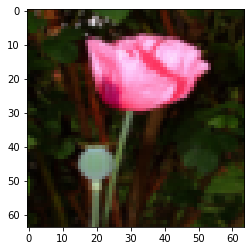

In [6]:
#Example of picture
# Viewing the random pixture from train data set
index=30
plt.imshow(train_set_x_orig[index])
print("y = "+str(train_set_y[:,index]) + " is a "+classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +" picture" )

In [8]:
print(np.squeeze(classes))

[b'non-cat' b'cat']


In [9]:
classes[np.squeeze(train_set_y[:, index])].decode("utf-8")

'non-cat'

In [7]:
## Exploring the train and test sets
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
print("Number of training examples "+str(m_train))
print("Number of testing examples "+str(m_test))
print("Image pixel size "+str(num_px))
print("Image Size "+str(num_px) + ", "+str(num_px)+ " ,"+"3")
print("train_set_x_orig shape "+str(train_set_x_orig.shape))
print("train_set_y shape "+str(train_set_y.shape))
print("test_set_x_orig shape "+str(test_set_x_orig.shape))
print("test_set_y shape"+str(test_set_y.shape))

Number of training examples 209
Number of testing examples 50
Image pixel size 64
Image Size 64, 64 ,3
train_set_x_orig shape (209, 64, 64, 3)
train_set_y shape (1, 209)
test_set_x_orig shape (50, 64, 64, 3)
test_set_y shape(1, 50)


In [8]:
## reshaping the test and training examples 
## expected shape (64*64*3 , m)

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


In [9]:
##Standardize the dataset , for images its simpler just divide it by 255 
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

#####  Building the helper functions for Algorithm

In [10]:
### Sigmoid function for the output layer.
def sigmoid(z):
    a = 1/(1+np.exp(-z))
    return a

In [11]:
print("sigmoid of [0 ,2] is " + str(sigmoid(np.array([0,2]))))

sigmoid of [0 ,2] is [0.5        0.88079708]


In [13]:
###Initializing the parameters of the model (W and b)
### Since it is a single node single layer model. It is ok to initialize parameters to zero's
### if it is deep network or multiple nodes then please use random initialization for W or preferabally HE initialization for Relu.
### expected dimenstions for W is (X_train.shape[0],1)
def initialize_with_zeros(dim):
    
    b = 0
    w = np.zeros((dim,1))
    
    assert(w.shape==(dim,1))
    assert(isinstance(b,float) or isinstance(b,int))
    
    return w,b

In [14]:
## Sanity check for initialization_with_zeros.
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


In [15]:
## Helper function for propagate
## implementing forward propagation to classify the Input
## implementing back ward propagation to derive the derivates of each neuron and layer to optimize the parameters using GradientDescent Learning algo
##Inputs to the function are parameters , X and y
## returns gradients and cost
def propagate(w,b,X,y):
    
    m = y.shape[1]
    
    #Forward propagation
    
    A = sigmoid(np.dot(w.T,X)+b)
    cost = -(np.dot(y,np.log(A.T)) + np.dot((1-y),np.log(1-A.T)))/m
    
    #Back propagation
    dZ = A - y
    dw = np.dot(X,dZ.T)/m
    db = np.sum(dZ)/m
    
    assert(dw.shape==w.shape)
    assert(db.dtype==float)
    cost = np.squeeze(cost)
    assert(cost.shape==())
    
    grads = {"dw":dw,
            "db":db}
    
    return grads,cost
             
    

In [16]:
###Sanity Check of propagate
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


In [17]:
### Using gradient descent algo to optimize the parameters.
### returns params , grads and costs of each iteration

def optimize(w,b,X,y,num_iterations,learning_rate,print_cost=False):
    
    costs=[]
    
    for i in range(num_iterations):
        grads,cost = propagate(w,b,X,y)
       
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate*dw
        db = b - learning_rate*db
        
        if(i%100==0):
            costs.append(cost)
            
        if(print_cost and i%100==0):
            print ("Cost after iteration %i: %f" %(i, cost))
            
    params = {"w":w,
              "b":b}
    grads = {"dw":dw,
             "db":db}
    
    return params,grads,costs
            

In [18]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19085485]
 [0.124599  ]]
b = 2.0
dw = [[0.67832892]
 [1.41526805]]
db = 1.9979668427508914


In [19]:
## Predicting using threshold as P(y|x) >= 0.5 is class 1 (cat) otherwise class 0 (non cat)
def predict(w,b,X):
    
    m = X.shape[1]
    w = w.reshape((X.shape[0],1))
    pred = sigmoid(np.dot(w.T,X) + b)
    
    pred[pred<0.5]=0
    pred[pred>=0.5]=1
    
    assert(pred.shape==(1,m))
    
    return pred

In [20]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


In [21]:
### Now building the model using defined helper functions.

def model(X_train,Y_train,X_test,Y_test,num_iterations=2000,learning_rate=0.01,print_cost=False):
    
    dim = X_train.shape[0]
    m = X_train.shape[1]
    
    #Initializing the parameters
    
    w,b = initialize_with_zeros(dim)
    
    #forward and backward propagation
    params,grads,costs = optimize(w,b,X_train,Y_train,num_iterations,learning_rate,print_cost)
    
    #retrieving parameters from the dictionary
    w = params["w"]
    b=  params["b"]
    
    predict_train = predict(w,b,X_train)
    predict_test = predict(w,b,X_test)
    
    #printing train and test errors
    print(np.mean(np.abs(Y_train - predict_train))*100)
    print("train accuracy: "+str(100 - np.mean(np.abs(Y_train - predict_train))*100) + " %")
    print("test accuracy: "+str(100 - np.mean(np.abs(Y_test - predict_test))*100) + " %")
    
    d = {"costs": costs,
         "Y_prediction_test": predict_test, 
         "Y_prediction_train" : predict_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d
    
    

In [23]:
### Fit and predict
### We can see train accuracy is 99% and test accuracy is 70%.
### it has high Variance
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584239
Cost after iteration 200: 0.466650
Cost after iteration 300: 0.375816
Cost after iteration 400: 0.331500
Cost after iteration 500: 0.303298
Cost after iteration 600: 0.279895
Cost after iteration 700: 0.260051
Cost after iteration 800: 0.242944
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214816
Cost after iteration 1100: 0.203073
Cost after iteration 1200: 0.192537
Cost after iteration 1300: 0.183026
Cost after iteration 1400: 0.174390
Cost after iteration 1500: 0.166513
Cost after iteration 1600: 0.159296
Cost after iteration 1700: 0.152659
Cost after iteration 1800: 0.146534
Cost after iteration 1900: 0.140864
0.9569377990430622
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


y = 1, you predicted that it is a "cat" picture.


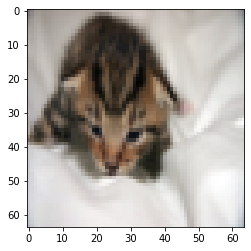

In [24]:
##Image that is wrongly classified
index = 1
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")

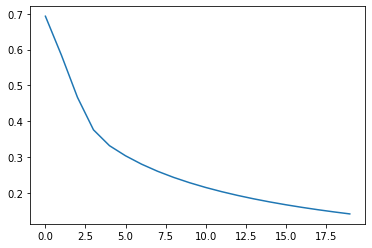

In [25]:
###Plotting costs vs number of iterations in 100's
plt.plot(np.squeeze(d["costs"]))

learning rate is: 0.01
0.4784688995215311
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
11.004784688995215
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
31.57894736842105
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



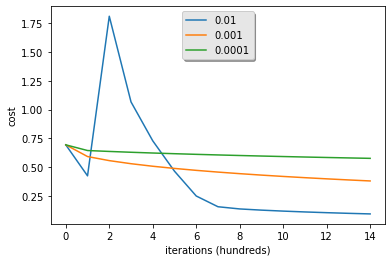

In [27]:
### Testing the model performance with different learning rates.
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

##Plotting the cost for every learning rate
for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

(1276, 1920, 3)
y = 0.0, your algorithm predicts a "non-cat" picture.


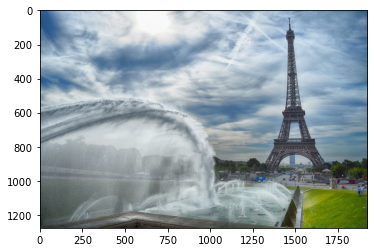

In [28]:
##Testing with own iMage
my_image = "my_image.jpg" 
import matplotlib.image as mpim
# preprocess the image to fit your algorithm.
fname = "images/" + my_image

image =np.array(mpim.imread(fname))
print(image.shape)
image = image/255.
##re-sizing the image
my_image = cv2.resize(image,(num_px,num_px)).reshape((1,num_px*num_px*3)).T

#my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

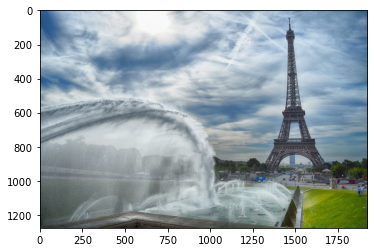

In [30]:
plt.imshow(image)

In [100]:
from scipy import misc